## - Calculate SFR and Mstar using UV+IR colors and W1, respectively.
## - Compare results with MAGPHYS outputs for unsaturated galaxies.
## - Generate Output Tables.

In [166]:
import numpy as np
from astropy.table import Table
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation as MAD
%matplotlib inline
from numpy import argsort

import os
homedir=os.getenv("HOME")

In [157]:
#first load the updated photometry catalog to have an idea of what fluxes are available and at
#what wavelength bands
phot_all = Table.read(homedir+'/Desktop/v2-20220820/virgofilaments-v3b-legacyphot.fits',hdu=2)
phot_names_all = Table.read(homedir+'/Desktop/v2-20220820/virgofilaments-v3b-legacyphot.fits',hdu=1)['VFID']
phot_maskbit_all = Table.read(homedir+'/Desktop/v2-20220820/virgofilaments-v3b-legacyphot.fits',hdu=3)['MASKBITS']
vf_all = Table.read(homedir+'/Desktop/v2-20220820/vf_v2_environment.fits')
magphys_all = Table.read(homedir+'/Desktop/v2-20220820/vf_v2_magphys_legacyExt_mergedNS.fits')

In [158]:
#has same effect as below cell
#nameflag = [item in phot_names_all for item in vf_all['VFID']]

In [159]:
nameflag = np.zeros(len(vf_all),dtype=bool)
for i in range(len(vf_all)):
    if vf_all[i]['VFID'] in phot_names_all:
        nameflag[i]=True
    else:
        nameflag[i]=False

In [178]:
#for whatever reason, the vf output table is not entirely row-matched to the phot table. 
#as such, the magphys output table will also not be entirely row-matched. I use np.argsort
#to correct this problem.

vf = vf_all[nameflag]
magphys = magphys_all[nameflag]

#I sort all tables in the same fashion...just to be absolutely certain of consistency.
ind = np.argsort(phot_names_all)
phot_names_all = phot_names_all[ind]
phot_all = phot_all[ind]
phot_maskbit_all = phot_maskbit_all[ind]

In [181]:
#I will also be removing galaxies with negative AP06 values in either W1, W4, or NUV.
#in W4, there are 1716 such galaxies; in NUV, 128 (though these galaxies ALSO have errant W4 values).
flux_flag = (phot_all['FLUX_AP06_NUV']>0) & (phot_all['FLUX_AP06_W4']>0) & (phot_all['FLUX_AP06_W1']>0) & (phot_all['FLUX_AP06_W2']>0)

#also...some galaxies with vcosmic<0. I'll just pluck these for now.
vel_flag = (vf['Vcosmic']>0)

In [182]:
vf = vf[flux_flag&vel_flag]
phot = phot_all[flux_flag&vel_flag]
phot_names = phot_names_all[flux_flag&vel_flag]
magphys = magphys[flux_flag&vel_flag]
phot_maskbit = phot_maskbit_all[flux_flag&vel_flag] #need to track [g,r,z] saturation, "medium", W1 star bits 

In [11]:
#MISC:

#RUN THIS CELL TO DETERMINE WHETHER THERE ARE ANY MISMATCHES BETWEEN ROWS. 
#I find 280 mismatches, in fact, where the VFID of phot_names != vf['VFID'] at the same index.
#problem is solved, however, when using np.sort. :-)

#vf['VFID'][np.sort(vf['VFID'])!=np.sort(phot_names_all)]

#for i in range(len(vf)):
#    print(i,vf['VFID'][i])
#    print(i,phot_names[i])

## (1) SFR

In [184]:
#COG_MTOT_* or FLUX_AP06_*, WHERE * = [FUV, NUV, g, r, z, W1, W2, W3, W4]
# corresponding wavelengths --> [.15 um, .22 um, .472 um, .642 um, .926 um, 3.4 um, 4.6 um, 12 um, 22 um]
# FUV, NUV wavelengths taken from 2022 NSF proposal
# note that phot['COG_MTOT_*'] are reported in AB magnitudes, not Vega!
# if it were Vega, then W4_AB = W4_Vega + 6.620 (from Jarrett+11 prescription)

In [185]:
#fW4_Jy = 10**(-0.4 * (w4_AB - 8.9))   #if I were using AB magnitudes. but no. I am using AP06 flux.

"The trouble with COG_MTOT_[G,R,Z] is that it's the asymptotic ("at infinity") magnitude based on fitting the curve of growth, so for non-isolated sources, poorly measured outer surface-brightness profiles, or imperfect masking...it's not going to be a reliable measure of the total magnitude."

$m_{AB,\nu} = -2.5\log_{10}\Big(\frac{f_{\nu}}{3631 Jy}\Big)$, which rearranges to become
<br>
$f_{\nu} = 10^{-0.4(m_{AB,\nu}-8.9)}$ Jy

Some conversions: <br>
$1$ Jy $= 10^{-26} W/Hz/m^2$ <br>
$f_0 = 3631$. (flux zeropoint for AB magnitude scale) <br>
$1$ nanomaggie $= 3.631x10^{-6}Jy$ <br>
$1$ maggie $= 10^{-0.4m_{AB}}$ <br>
$1$ Watt $= 1x10^7$ erg/s

In [186]:
vcosmic = vf['Vcosmic']  #km/s          #vcosmic? vr? will decide which to use later.
dist_km = (vcosmic/68.)*3.08e19         #assume H0 = 68 km/s/Mpc; 1 Mpc = 3.08e19 km 
dist_meters = dist_km*1.e3

In [187]:
#next, we need nu*L_nu, which comprises the spectral energy density for nu = W4
#remember that c = lambda*nu, so nu = c/lambda ...
#and L_nu = f_nu * 4piD, where D is the flow-corrected distance
wave_W4 = 22.e-6
freq_W4 = 3.e8/wave_W4   #units are Hz

In [188]:
w4_AP06_flux = phot['FLUX_AP06_W4']   #nanomaggies

fW4_Jy = (w4_AP06_flux * 3.631e-6)  #Jy

fW4_mks = fW4_Jy * 1.e-26   #W/m^2/Hz

In [189]:
nuL_22 = freq_W4 * fW4_mks * (4*np.pi*dist_meters**2) #units are Watts
nuL_22 = nuL_22 * 1.e7   #erg/s

In [190]:
#from the formula in Kennicutt & Evans (2012), for which I NEED erg/s (hence the conversion above),

$\log_{10}(SFR_{22}) = \log_{10}(\nu L_{\nu, 22}) - 42.69$

In [191]:
logSFR_W4 = np.log10(nuL_22) - 42.69

In [192]:
#do likewise for the NUV (corrected).

$\log_{10}(SFR_{NUV_{corr}}) = \log_{10}(\nu L_{\nu_{corr}}) - 43.17$
<br>
<br>
$L_{\nu_{NUV,corr}} = \nu_{NUV}L_{\nu_{NUV}} + 2.26\nu_{22}L_{\nu_{22}}$
(Kennicutt & Evans 2012 --> one caveat is that they report the relation for 25 microns, not 22 microns)

In [193]:
NUV_AP06_flux = phot['FLUX_AP06_NUV']

fNUV_Jy = NUV_AP06_flux * 3.631e-6   #Jy

fNUV_mks = fNUV_Jy * 1.e-26   #W/m^2/Hz

In [194]:
wave_NUV = 0.22e-6
freq_NUV = 3.e8/wave_NUV   #units are Hz

In [195]:
nuL_NUV = freq_NUV * fNUV_mks * (4*np.pi*dist_meters**2)*1.e7 #units are egs/s/Hz

In [196]:
nuL_NUV_corrected = (nuL_NUV) + (2.26*nuL_22)

In [197]:
logSFR_NUV_corrected = np.log10(nuL_NUV_corrected) - 43.17

## (2) Mstar

#### Jarrett+23 --> two equations

This first equation accounts for $7 < log_{10}(L_{W1}) < 12$: <br>
$\log_{10}(M_*) = A_0 + A_1(\log_{10}(L_{W1})) + A_2(\log_{10}(L_{W1}))^2 + A_3(\log_{10}(L_{W1}))^3$, <br>
where <br>
$A_0 = -12.62185$ <br>
$A_1 = 5.00155$ <br>
$A_2 = -0.43857$ <br>
$A_3 = 0.01593$ <br> <br>
Second equation:
$\log_{10}(M_*) = A_0 + A_1C_{12} + \log_{10}(L_{W1})$, <br>
where <br>
$A_0 = -0.376$ <br>
$A_1 = -1.053$ <br>
$C_{12} = W1 - W2$ color in Vega magnitudes

$L_{W1}[L_\odot] = 10^{-0.4(M - M_\odot)}$, where M is the absolute magnitude of the source in W1 (determined with the distance modulus) and M$_\odot$ in W1 is 3.26 (Vega) or 5.92 (AB) --> both values are from Jarrett+11. (https://mips.as.arizona.edu/~cnaw/sun.html)

In [198]:
w1_AP06_flux = phot['FLUX_AP06_W1']    #nanomaggies
w2_AP06_flux = phot['FLUX_AP06_W2']    #nanomaggies
fW1_Jy = w1_AP06_flux * 3.631e-6   #Jy
fW2_Jy = w2_AP06_flux * 3.631e-6   #Jy

In [199]:
w1_magAB = 22.5 - 2.5 * np.log10(w1_AP06_flux)
w2_magAB = 22.5 - 2.5 * np.log10(w2_AP06_flux)

#supposedly...m_Vega = m_AB - mag_offset, where
#mag_offset_W1 = 2.699
#mag_offset_W2 = 3.339
#(source: https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#conv2flux)

w1_magVega = w1_magAB - 2.699
w2_magVega = w2_magAB - 3.339

In [200]:
#and now, the distance modulus formula. our first task is to calculate L_W1.

$m_{AB} - M_{AB} = 5\log\Big( \frac{D}{10} \Big)$, <br>
where D is distance in parsecs.

In [201]:
dist_mpc = (vcosmic/68.)
dist_pc = dist_mpc*1.e6
w1_absmag_AB = w1_magAB - 5*np.log10(dist_pc/10.)

In [202]:
sun_absmag_AB = 5.92

In [203]:
L_W1 = 10**(-0.4 * (w1_absmag_AB - sun_absmag_AB))   #units of solar luminosities
logL_W1 = np.log10(L_W1)

In [204]:
#FIRST EQUATION

A0 = -12.62185
A1 = 5.00155
A2 = -0.43857
A3 = 0.01593

logMstar = A0 + A1*logL_W1 + A2*(logL_W1**2) + A3*(logL_W1**3)

In [205]:
#SECOND EQUATION
A0 = -0.376
A1 = -1.053
C_12 = w1_magVega - w2_magVega

logMstar_2 = A0 + A1*C_12 + logL_W1

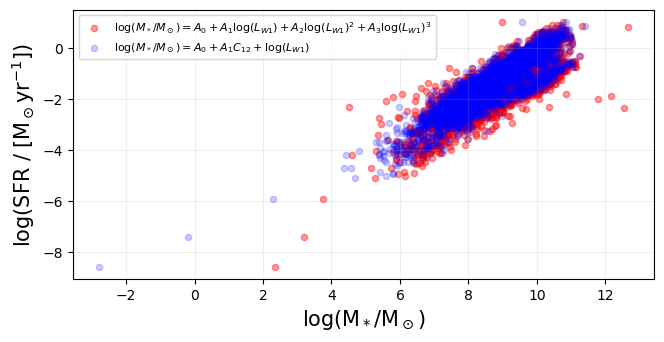

In [206]:
plt.figure(figsize=(7.5,3.5))
plt.scatter(logMstar_2,logSFR_NUV_corrected,s=20,alpha=0.4,color='red',label=r'$\log(M_*/M_\odot) = A_0 + A_1\log(L_{W1}) + A_2\log(L_{W1})^2 + A_3\log(L_{W1})^3$')

plt.scatter(logMstar,logSFR_NUV_corrected,s=20,alpha=0.2,color='blue',label='$\log(M_*/M_\odot) = A_0 + A_1C_{12} + \log(L_{W1})$')
plt.grid(alpha=0.2)
plt.xlabel(r'log(M$_*$/M$_\odot$)',fontsize=15)
plt.ylabel(r'log(SFR / [M$_\odot$yr$^{-1}$])',fontsize=15)

plt.legend(fontsize=8)
plt.show()

## (3) Comparison with MAGPHYS

In [207]:
#let's compare with MAGPHYS values...but the non-saturated galaxies only. 
#I identify these galaxies using the maskbit "saturation" and "medium" bits
logmass = magphys['logMstar_med']
logsfr = magphys['logSFR_med']

In [208]:
gsaturation = (phot_maskbit & 2**2) == 2**2
rsaturation = (phot_maskbit & 2**3) == 2**3
zsaturation = (phot_maskbit & 2**4) == 2**4
medium = (phot_maskbit & 2**11) == 2**11
wisestar = (phot_maskbit & 2**8) == 2**8

In [209]:
sat_flags = (gsaturation | rsaturation | zsaturation)
medium_flag = medium
wisestar_flag = wisestar
fitflags = (sat_flags | medium_flag | wisestar_flag)

In [210]:
all_flags = (fitflags) & (logmass>6.)

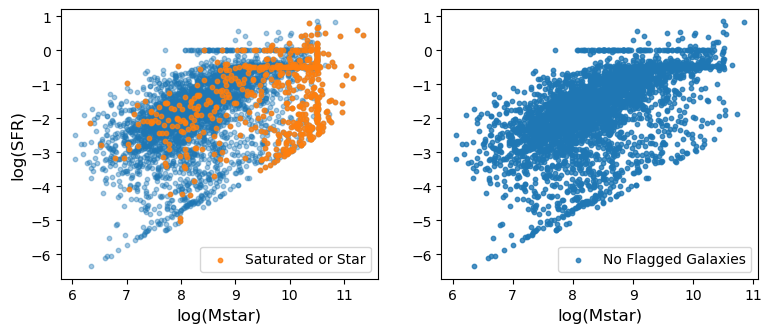

flag count: 539


In [211]:
plt.subplots(1,2,figsize=(9,3.5))
plt.subplot(1,2,1)
plt.scatter(logmass[logmass>6.], logsfr[logmass>6.], s=10, alpha=0.4)
plt.scatter(logmass[all_flags], 
            logsfr[all_flags], alpha=0.8, s=10, label='Saturated or Star')
plt.xlabel('log(Mstar)',fontsize=12)
plt.ylabel('log(SFR)',fontsize=12)
plt.legend()
plt.subplot(1,2,2)
plt.scatter(logmass[~fitflags & (logmass>6.)], 
            logsfr[~fitflags & (logmass>6.)], alpha=0.8, s=10, label='No Flagged Galaxies')
plt.xlabel('log(Mstar)',fontsize=12)
plt.legend()
plt.show()
print(f'flag count: {len(logsfr[all_flags])}')

In [212]:
#this process doesn't remove all of the problematic galaxies, unfortunately.

In [213]:
magphys_mstar = logmass[~fitflags & (logmass>8.)]
magphys_sfr = logsfr[~fitflags & (logmass>8.)]

In [214]:
#from the above derivations, we have:
    #logSFR_NUV_corrected
    #logSFR_W4
    #logMstar
    #logMstar_2

In [215]:
#finding quantitative relationships and parameter uncertainties
p_sfr_nuv,cov1a = np.polyfit(magphys_sfr,(logSFR_NUV_corrected[~fitflags & (logmass>8.)]),1,cov=True)
p_sfr_w4,cov2a = np.polyfit(magphys_sfr,(logSFR_W4[~fitflags & (logmass>8.)]),1,cov=True)
p_sfr_nuv_alt,cov1 = np.polyfit(magphys_sfr[(magphys_sfr!=0)],(logSFR_NUV_corrected[~fitflags & (logmass>8.)])[(magphys_sfr!=0)],1,cov=True)
p_sfr_w4_alt,cov2 = np.polyfit(magphys_sfr[(magphys_sfr!=0)],(logSFR_W4[~fitflags & (logmass>8.)])[magphys_sfr!=0],1,cov=True)
p_mstar,cov1b = np.polyfit(magphys_mstar,logMstar[~fitflags & (logmass>8.)],1,cov=True)
p_mstar_2,cov2b = np.polyfit(magphys_mstar,logMstar_2[~fitflags & (logmass>8.)],1,cov=True)

In [216]:
#fit lines to data
p_mstar_line = np.poly1d(p_mstar)
p_mstar_2_line = np.poly1d(p_mstar_2)

p_sfr_nuv_line = np.poly1d(p_sfr_nuv)
p_sfr_w4_line = np.poly1d(p_sfr_w4)

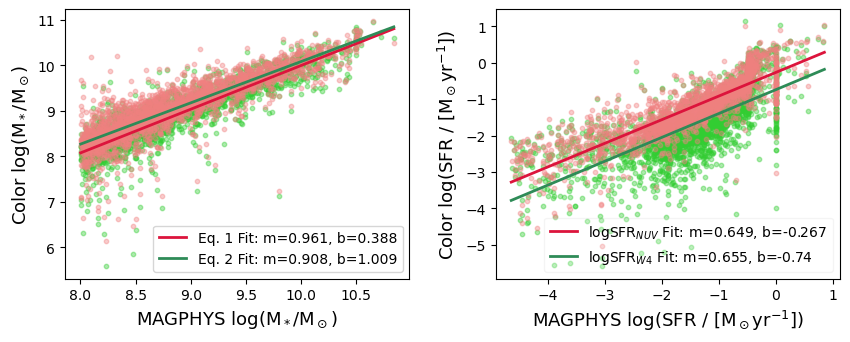

In [217]:
#create range of x values for the plotting of fitted lines
x_p_mstar = np.linspace(np.min(magphys_mstar),np.max(magphys_mstar),1000)
x_p_sfr = np.linspace(np.min(magphys_sfr),np.max(magphys_sfr),1000)

plt.subplots(1,2,figsize=(10,3.5))

plt.subplot(1,2,1)
plt.scatter(magphys_mstar,logMstar[~fitflags & (logmass>8.)], 
            alpha=0.4, s=10, color='limegreen')
plt.scatter(magphys_mstar,logMstar_2[~fitflags & (logmass>8.)], 
            alpha=0.4, s=10, color='lightcoral')
plt.plot(x_p_mstar,p_mstar_line(x_p_mstar),color='crimson',
         label=f'Eq. 1 Fit: m={np.round(p_mstar[0],3)}, b={np.round(p_mstar[1],3)}',
         linewidth=2,zorder=2)
plt.plot(x_p_mstar,p_mstar_2_line(x_p_mstar),color='seagreen',
         label=f'Eq. 2 Fit: m={np.round(p_mstar_2[0],3)}, b={np.round(p_mstar_2[1],3)}',
         linewidth=2,zorder=2)
plt.xlabel(r'MAGPHYS log(M$_*$/M$_\odot$)',fontsize=13)
plt.ylabel('Color log(M$_*$/M$_\odot$)',fontsize=13)
plt.legend()

plt.subplot(1,2,2)
plt.scatter(magphys_sfr,logSFR_W4[~fitflags & (logmass>8.)], alpha=0.4, s=10, color='limegreen')
plt.scatter(magphys_sfr,logSFR_NUV_corrected[~fitflags & (logmass>8.)], alpha=0.4, s=10, color='lightcoral')
plt.plot(x_p_sfr,p_sfr_nuv_line(x_p_sfr),color='crimson',
         label=r'logSFR$_{NUV}$ '+ f'Fit: m={np.round(p_sfr_nuv[0],3)}, b={np.round(p_sfr_nuv[1],3)}',
         linewidth=2,zorder=2)
plt.plot(x_p_sfr,p_sfr_w4_line(x_p_sfr),color='seagreen',
         label=r'logSFR$_{W4}$ '+ f'Fit: m={np.round(p_sfr_w4[0],3)}, b={np.round(p_sfr_w4[1],3)}',
         linewidth=2,zorder=2)
plt.xlabel(r'MAGPHYS log(SFR / [M$_\odot$yr$^{-1}$])',fontsize=13)
plt.ylabel(r'Color log(SFR / [M$_\odot$yr$^{-1}$])',fontsize=13)
plt.legend(framealpha=0.2,fancybox=True)

plt.subplots_adjust(wspace=0.25)
plt.show()

In [218]:
print('CurveFit Parameters log(Mstar)')
print(f'log(Mstar): m={np.round(p_mstar[0],3)} +/- {np.round(np.sqrt(cov1b[0][0]),3)}, b={np.round(p_mstar[1],3)} +/- {np.round(np.sqrt(cov1b[1][1]),3)}')
print(f'log(Mstar)_2: m={np.round(p_mstar_2[0],3)} +/- {np.round(np.sqrt(cov2b[0][0]),3)}, b={np.round(p_mstar_2[1],3)} +/- {np.round(np.sqrt(cov2b[1][1]),3)}')

CurveFit Parameters log(Mstar)
log(Mstar): m=0.961 +/- 0.01, b=0.388 +/- 0.092
log(Mstar)_2: m=0.908 +/- 0.011, b=1.009 +/- 0.095


In [219]:
print('CurveFit Parameters log(SFR)')
print(f'log(SFR)_NUV: m={np.round(p_sfr_nuv[0],3)} +/- {np.round(np.sqrt(cov1a[0][0]),3)}, b={np.round(p_sfr_nuv[1],3)} +/- {np.round(np.sqrt(cov1a[1][1]),3)}')
print(f'log(SFR)_W4: m={np.round(p_sfr_w4[0],3)} +/- {np.round(np.sqrt(cov2a[0][0]),3)}, b={np.round(p_sfr_w4[1],3)} +/- {np.round(np.sqrt(cov2a[1][1]),3)}')

CurveFit Parameters log(SFR)
log(SFR)_NUV: m=0.649 +/- 0.008, b=-0.267 +/- 0.014
log(SFR)_W4: m=0.655 +/- 0.013, b=-0.74 +/- 0.023


In [220]:
print('CurveFit Parameters Excluding log(SFR)_magphys=0 Points')
print(f'log(SFR)_NUV: m={np.round(p_sfr_nuv_alt[0],3)} +/- {np.round(np.sqrt(cov1[0][0]),3)}, b={np.round(p_sfr_nuv_alt[1],3)} +/- {np.round(np.sqrt(cov1[1][1]),3)}')
print(f'log(SFR)_W4: m={np.round(p_sfr_w4_alt[0],3)} +/- {np.round(np.sqrt(cov2[0][0]),3)}, b={np.round(p_sfr_w4_alt[1],3)} +/- {np.round(np.sqrt(cov2[1][1]),3)}')

CurveFit Parameters Excluding log(SFR)_magphys=0 Points
log(SFR)_NUV: m=0.662 +/- 0.008, b=-0.237 +/- 0.014
log(SFR)_W4: m=0.666 +/- 0.013, b=-0.716 +/- 0.024


0.06365599485952167
0.2058550241709797


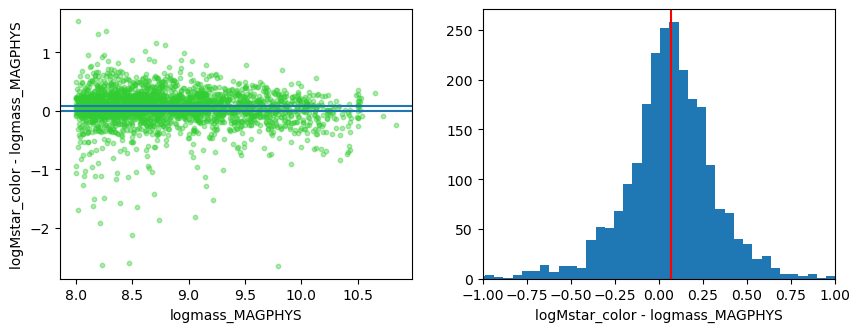

In [221]:
plt.subplots(1,2,figsize=(10,3.5))
plt.subplot(1,2,1)
plt.scatter(magphys_mstar,logMstar[~fitflags & (logmass>8.)] - magphys_mstar, 
            alpha=0.4, s=10, color='limegreen')
plt.axhline(0)
plt.xlabel('logmass_MAGPHYS')
plt.ylabel('logMstar_color - logmass_MAGPHYS')
print(np.median(logMstar[~fitflags & (logmass>8.)] - magphys_mstar))
plt.axhline(0.0702)
plt.subplot(1,2,2)
plt.hist(logMstar[~fitflags & (logmass>8.)] - magphys_mstar,bins=80)
plt.xlim(-1,1)
plt.axvline(0.07,color='red')
plt.xlabel('logMstar_color - logmass_MAGPHYS')
#print(np.std(logMstar[~fitflags & (logmass>8.)] - magphys_mstar))  --> 0.0702
print(MAD(logMstar[~fitflags & (logmass>8.)] - magphys_mstar) * 1.4826)

## (4) Creating Output Table for Color Magnitude SFR, Mstar

In [222]:
unsaturated = np.zeros(len(magphys_all),dtype=bool)
not_pointsource= np.zeros(len(magphys_all),dtype=bool)

for i in range(len(magphys_all)):
    if magphys_all['VFID'][i] in phot_names_all:
        index = np.where(phot_names_all == magphys_all['VFID'][i])[0][0]
        unsaturated[i] = ~((phot_maskbit_all[index] & 2**2) == 2**2) & ~((phot_maskbit_all[index] & 2**2) == 2**2) & ~((phot_maskbit_all[index] & 2**2) == 2**2)
        not_pointsource[i] = ~((phot_maskbit_all[index] & 2**11) == 2**11)
    else:
        unsaturated[i]=True
        not_pointsource[i]=True

In [223]:
errant_magphys_VFIDs = magphys_all[~unsaturated | ~not_pointsource | ~magphys_all['magphysFlag']]['VFID']
print(f'# of VF galaxies that are saturated, have no MAGPHYS results, or were treated as a point source: {len(errant_magphys_VFIDs)}')

# of VF galaxies that are saturated, have no MAGPHYS results, or were treated as a point source: 592


In [224]:
#retaining galaxies with positive AP06 flux values
flux_flag = (phot_all['FLUX_AP06_NUV']>0) & (phot_all['FLUX_AP06_W4']>0) & (phot_all['FLUX_AP06_W1']>0) & (phot_all['FLUX_AP06_W2']>0)

#also...some galaxies with vcosmic<0. I'll just pluck these for now.
#note that the nameflag ensures only galaxies in phot_all are included in vf_all
vel_flag = (vf_all[nameflag]['Vcosmic']>0)

In [225]:
good_phot = phot_all[flux_flag&vel_flag]  #same length as logMstar, logMstar_2, logSFR_NUV_corrected
good_phot_VFIDs = phot_names_all[flux_flag&vel_flag]

In [226]:
counter=0
for VFID in errant_magphys_VFIDs:
    if VFID in good_phot_VFIDs:
        counter+=1
print(f'# errant MAGPHYS galaxies with robust photometry: {counter}')

# errant MAGPHYS galaxies with robust photometry: 215


In [227]:
phot_sfrmstar = Table([phot_names, logMstar, logMstar_2, 
                 logSFR_NUV_corrected, logSFR_W4, magphys['magphysFlag'],
                 (unsaturated[nameflag])[flux_flag&vel_flag], (not_pointsource[nameflag])[flux_flag&vel_flag]],
                names=['VFID', 'logMstar_1', 'logMstar_2', 
                       'logSFR_NUVcorr', 'logSFR_W4', 
                       'magphys_flag', 'unsaturated', 'not_pointsource'])

## (5) Creating Table with Alternate MAGPHYS SFR, Mstar Values

$y = mx+b$ <br>
$x = \frac{y-b}{m}$

In [228]:
magphys_mstar_alt1 = (logMstar - p_mstar[1])/p_mstar[0]
magphys_mstar_alt2 = (logMstar_2 - p_mstar_2[1])/p_mstar_2[0]

In [229]:
magphys_sfr_alt = (logSFR_NUV_corrected - p_sfr_nuv[1])/p_sfr_nuv[0]

In [230]:
magphys_alt = Table([phot_names,magphys_mstar_alt1,magphys_mstar_alt2,magphys_sfr_alt],
                    names=['VFID','logMstar_med_alt1','logMstar_med_alt2','logSFR_med_alt'])

Propagating uncertainties. Should I also include MAGPHYS output uncertainties..? 

Note: <br>
$\Delta x = \sqrt{\Big( \Delta \frac{y}{m}\Big) ^2 + \Big( \Delta \frac{b}{m}\Big) ^2}$ 

$\Delta (b/m) = \frac{b}{m}\sqrt{(\Delta b)^2 + (\Delta m)^2 }$

$\Delta (y/m) = \frac{y}{m}\Delta m$

In [234]:
os.chdir(homedir+'/github/research/SFRMstar')

In [235]:
%run color_sfrmstar.py

CurveFit Parameters log(Mstar_color) = mlog(Mstar_MAGPHYS) + b
m=0.931 +/- 0.009, b=0.804 +/- 0.072

CurveFit Parameters log(SFR_color) = mlog(SFR_MAGPHYS) + b
m=0.708 +/- 0.007, b=-0.287 +/- 0.014


Table written to /Users/k215c316/Desktop/vf-altphot.fits


<Figure size 640x480 with 0 Axes>

In [236]:
tab=phot_table.out_tab

In [237]:
tab[tab['good_phot_flag'] & (~tab['unsaturated_flag'] | ~tab['nowisestar_flag'] | ~tab['nomedstar_flag'])]

VFID,logMstar_C12,logSFR_color,MAGPHYS_logMstar_med,alt_logMstar_med,alt_logMstar_med_err,MAGPHYS_logSFR_med,alt_logSFR_med,alt_logSFR_med_err,magphys_flag,unsaturated_flag,nowisestar_flag,nomedstar_flag,good_phot_flag
bytes8,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool
VFID0002,10.269542486583243,0.23490311629953453,10.34,10.172239344158024,0.09852787577038798,-0.248,0.7377634461475717,0.006715261033765019,True,False,True,True,True
VFID0008,10.342121816942853,0.30563300902224455,10.46,10.250235536814051,0.09916243854962177,-0.363,0.8377321793232546,0.006965695262736538,True,False,True,True,True
VFID0013,10.381358834680027,-0.1976395835811573,10.47,10.292400957458103,0.09950565219153565,-0.698,0.12641308087862263,0.0066068376933249625,True,False,True,True,True
VFID0018,10.922392393421362,-0.7114266494411012,10.77,10.873813840049927,0.10424923216291562,-2.098,-0.5997670406922132,0.0092469795643325,True,False,True,False,True
VFID0019,10.479351717939583,0.25317327774026666,10.5,10.397707409911751,0.10036330645846914,-0.108,0.7635862605735119,0.006774500119520372,True,False,True,True,True
VFID0020,10.168976176614166,0.6631148576478267,9.532,10.064167400697123,0.0976492833366381,0.0,1.342992489564418,0.008919393672045774,True,False,True,False,True
VFID0024,10.797862615535658,-0.6926965054553946,10.5,10.739989946948942,0.10315564567334369,-1.718,-0.573294092772019,0.00911865113187128,True,False,True,True,True
VFID0026,9.838134986264226,-0.5577615698644323,9.962,9.708634315819788,0.09476457721867017,-0.948,-0.38257876643815447,0.008247966838579413,True,False,True,True,True
VFID0037,9.847368994572708,-1.7627744796178888,9.447,9.71855749212146,0.09484496879963578,-3.513,-2.0857287276668948,0.017849879782788996,True,False,True,True,True
